<h1><b>Statistique en Bioinformatique : </b> TME5 et 6 </h1>
<br>
L’objectif de ce TME est: 
<br>
<ul>
<li> implémenter l'algorithme de Viterbi et l'estimation des paramètres (en utilisant le Viterbi training)
pour l'exemple du occasionally dishonest casino.   </li> 
</ul>
<br>
<div class="alert alert-warning" role="alert" style="margin: 10px">
<p>**Soumission**</p>
<ul>
<li>Renommer le fichier TME5_6.ipynb pour NomEtudiant1_NomEtudiant2_TME5_6.ipynb </li>
</ul>
</div>

Nom etudiant 1 :
Alexis Trang

Nom etudiant 2 :
Yann Zhong

<h3>Introduction</h3>
Un casino parfois malhonnête (occasionally dishonest casino) utilise 2 types de pieces : fair et unfair. <br>
La matrice de transition entre les états cachés est:<br>
${\cal S}=\{F,U\}$ (fair, unfair):
$$
p = \left(
\begin{array}{cc}
0.99 & 0.01\\
0.05 & 0.95
\end{array}
\right)\ ,
$$

les probabilités d'éemission des symboles 
${\cal O} = \{H,T\}$ (head, tail):
\begin{eqnarray}
e_F(H) =  0.5 &\ \ \ \ &
e_F(T) = 0.5 \nonumber\\
e_U(H) = 0.9 &\ \ \ \ &
e_U(T) = 0.1 \nonumber
\end{eqnarray}

<br> Et la condition initiale $\pi^{(0)} = (1,0)$ (le jeux commence toujours avec le pieces juste (fair).

<b>Exercice 1</b>:
<u>Simulation</u>: Ecrire une fonction qui simule $T$ jets de pieces. 
La fonction renverra un tableau à deux colonnes correspondant 
aux valeurs simulées pour les états cachés $X_t$ 
(type de dés utilisée, “F” ou “U”) et aux symboles observées $Y_t$ 
(résultat du jet de dés, “H” ou “T”). On simulera une séquence
de longueur 2000 qu'on gardera pour les applications ultérieures.


In [72]:
import numpy as np
import matplotlib.pyplot as plt


S = {0:'F',1 :'U'}
Pij = np.array([[0.99,0.01], [0.05,0.95]])

O = {0:'H', 1: 'T'}
Eio = np.array([[0.5,0.5], [0.9,0.1]])

# Initial condition
pi0 = np.array([0.999,0.001]) # Random initial condition set to "unfair"
# We want to avoid the "0" probability described above, so this is a non-zero approximation which
# will serve our purpose quite well.

T = 2000

In [73]:
import random

# Simulate T coin tosses 
def toss_coin(T, Eij, Pij):
    
    # Initialisation
    tosses=np.zeros((T,2),str)
    pi = np.array([0.999,0.001])
    
    piece = 0  # flag to set initial condition to fair
    
    for i in range(T):
        
        r = random.random()
        if r<Eij[piece][0]:
            tosses[i]=S[piece],O[0]
        else:
            tosses[i]=S[piece],O[1]
        
        s = random.random()
        if s<Pij[piece][0]:
            piece = 0
        else:
            piece = 1
            
    return tosses  # matrix (T,2) of T coin tosses c corresponding to T hidden states h [[h0, c0], ..., [hT-1, cT-1]]

[['F' 'T']
 ['F' 'T']
 ['F' 'H']
 ...
 ['U' 'H']
 ['U' 'H']
 ['U' 'H']]


(array([ 865., 1135.]), array([2. , 2.5, 3. ]), <a list of 2 Patch objects>)

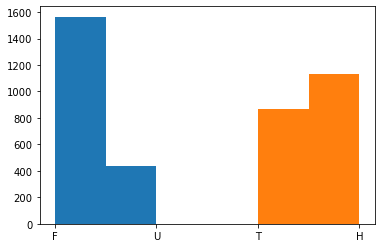

In [74]:
tosses = toss_coin(2000,Eio,Pij)
print(tosses)

states = []
observations = []
for i in range(len(tosses)):
    states.append(tosses[i][0])
    observations.append(tosses[i][1])

plt.hist(states, density=False, bins=2)
plt.hist(observations, density=False, bins=2)

<b>Exercice 2</b>: <u>Algorithme de Viterbi </u>: Ecrire une fonction qui permet
de déterminer la séquence $(i^\star_t)_{t=0:T}$ d'états cachés
plus probable, ansi que sa probabilité. Pour tester votre fonction utiliser le résultat de la 
simulation (2éme colonne) de la question 1. Comparer $(i^\star_t)_{t=0:T}$ avec
les vrais états cachés (1ère colonne de la simulation). 


In [109]:
# Algorithme de Viterbi ==> VERSION 1, DO NOTE USE, use as reference
def viterbi(jets,P,E,pi):
    
    best_tosses, best_prob="",0                  # initialize return values
    
    valeurs=np.zeros((2,len(jets)))              # table to store calculated log probabilities
    fleches=np.zeros((2,len(jets)))              # table to store where the maximum came from in previous time
    
    valeurs[0][0]=np.log(pi[0]*E[0][jets[0]])    # initialisation par le log produit de la condition initiale (pi)
    valeurs[1][0]=np.log(pi[0]*E[1][jets[0]])    # par la probabilité de l'observation

    # TABLEAUX
    for i in range(1,len(jets)):                 # on loop à partir de 1 car on a déjà initialisé
        
        # Calcul de la ligne correspondant au premier état
        prev_state_0_to_0 = valeurs[0][i-1]+np.log(P[0][0])+np.log(E[0][jets[i]])
        prev_state_1_to_0 = valeurs[1][i-1]+np.log(P[1][0])+np.log(E[0][jets[i]])
        prev_state_max_0 = max(prev_state_0_to_0,prev_state_1_to_0)
        
        if prev_state_max_0 == prev_state_0_to_0:
            fleches[0][i] = 0                    # →
        else:
            fleches[0][i] = 1                    # ↗
        valeurs[0][i] = prev_state_max_0         # add the max value to the table for first state
        
        # Calcul de la ligne correspondant au second état
        prev_state_0_to_1 = valeurs[0][i-1]+np.log(P[0][1])+np.log(E[1][jets[i]]) 
        prev_state_1_to_1 = valeurs[1][i-1]+np.log(P[1][1])+np.log(E[1][jets[i]])
        prev_state_max_1 = max(prev_state_0_to_1,prev_state_1_to_1)
        
        if prev_state_max_1 == prev_state_0_to_1:
            fleches[1][i] = -1                  # ↘
        else:
            fleches[1][i] = 0                   # → 
        valeurs[1][i] = prev_state_max_1        # add the max value to the table for second state

    # TRACE BACK

    last_col_0,last_col_1 = valeurs[0][-1],valeurs[1][-1]   # last column of the value table (the max will give us the probability)
    last_col_max = max(last_col_0,last_col_1)
    best_prob = last_col_max                         
    
    if last_col_max == last_col_0:
        best_tosses = "F"
        d = 0                              # flag: current best state is first state
    else:
        best_tosses = "U"
        d = 1                              # flag: current best state is second state

    for j in range(len(jets)-1,1,-1):
        if d == 0:                         # if the previous best state is the first state...
            if fleches[d][j] == 0:
                best_tosses += "F"
            else:
                best_tosses += "U"
                d = 1
        if d == 1:                         # if the previous best state is the second state...
            if fleches[d][j] == 0:
                best_tosses += "U"
            else:
                best_tosses += "F"
                d = 0

    return best_tosses, best_prob

In [111]:
# Algorithme de Viterbi ==> VERSION 2, USE THIS ONE
def viterbi(jets,P,E,pi):  #### jets correspond à la liste d'états observés ex: ['H','H','T'...]

    obs='HT'
    bin_jets=[]
    for i in jets:
        bin_jets.append(obs.index(i))

    best_tosses, best_prob="",0                  # initialize return values

    valeurs=np.zeros((2,len(bin_jets)))              # table to store calculated log probabilities
    fleches=np.zeros((2,len(bin_jets)))              # table to store where the maximum came from in previous time

    valeurs[0][0]=np.log(pi[0]*E[0][bin_jets[0]])    # initialisation par le log produit de la condition initiale (pi)
    valeurs[1][0]=np.log(pi[0]*E[1][bin_jets[0]])    # par la probabilité de l'observation

    # TABLEAUX
    for i in range(1,len(bin_jets)):                 # on loop à partir de 1 car on a déjà initialisé

        # Calcul de la ligne correspondant au premier état
        prev_state_0_to_0 = valeurs[0][i-1]+np.log(P[0][0])+np.log(E[0][bin_jets[i]])
        prev_state_1_to_0 = valeurs[1][i-1]+np.log(P[1][0])+np.log(E[0][bin_jets[i]])
        prev_state_max_0 = max(prev_state_0_to_0,prev_state_1_to_0)

        if prev_state_max_0 == prev_state_0_to_0:
            fleches[0][i] = 0                    # →
        else:
            fleches[0][i] = 1                    # ↗
        valeurs[0][i] = prev_state_max_0         # add the max value to the table for first state

        # Calcul de la ligne correspondant au second état
        prev_state_0_to_1 = valeurs[0][i-1]+np.log(P[0][1])+np.log(E[1][bin_jets[i]])
        prev_state_1_to_1 = valeurs[1][i-1]+np.log(P[1][1])+np.log(E[1][bin_jets[i]])
        prev_state_max_1 = max(prev_state_0_to_1,prev_state_1_to_1)

        if prev_state_max_1 == prev_state_0_to_1:
            fleches[1][i] = -1                  # ↘
        else:
            fleches[1][i] = 0                   # →
        valeurs[1][i] = prev_state_max_1        # add the max value to the table for second state
    # TRACE BACK

    last_col_0,last_col_1 = valeurs[0][-1],valeurs[1][-1]   # last column of the value table (the max will give us the probability)
    last_col_max = max(last_col_0,last_col_1)
    best_prob = last_col_max

    if last_col_max == last_col_0:
        best_tosses = ["F"]
        d = 0                              # flag: current best state is first state
    else:
        best_tosses = ["U"]
        d = 1                              # flag: current best state is second state

    for j in range(len(bin_jets)-1,0,-1):
        if d == 0:                         # if the previous best state is the first state...
            if fleches[d][j] == 0:
                best_tosses += ["F"]
            else:
                best_tosses += ["U"]
                d = 1
        elif d == 1:                         # if the previous best state is the second state...
            if fleches[d][j] == 0:
                best_tosses += ["U"]
            else:
                best_tosses += ["F"]
                d = 0

    return best_tosses, best_prob

In [122]:
# Calculate the difference between the Viterbi solution and the simulation

viterbi(jets[:,1],Pij,Eio,pi0)

(['U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'U',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',
  'F',

<b>Exercice 3</b>: <u>Estimation des paramètres</u>
<br>
3.1) Ecrire une fonction qui utilise tous les résultats de la simulation
(états et symboles) pour compter les nombres d'occurrence $N_{ij}$ est $M_{iO}$ définis
en cours. Estimer $p_{ij}$ est $e_i(O)$, voir slides  37-39 dans la presentation. Attention, pour eviter les probabilites à zero nous allons utiliser les pseudo-count.

In [19]:
# Parameter estimation by counting
def occurrences(jets, nS, nO):
    #Initialisation à zéro
    pi0=np.array((0.5, 0.5))  # Initial: 0.5 and 0.5 to ensure neutral starting probabilities
    Eio=np.zeros((nS,nO))     # Emissions:states by observations ==> 6 by 2 for dice, for example (2 by 2 for coin)
    Pij=np.zeros((nS,nS))     # Transitions:observations by observations

    états='FU'                # Fair Unfair
    obs='HT'                  # Heads Tails
    
    Eio[états.index(jets[0][0])][obs.index(jets[0][1])]=1 # Initialisation en regardant le premier tirage
    
    count_F=list(jets[:,0]).count('F') # On compte le nb d'occurences de F dans notre jet
    if count_F==0:            # Si on trouve pas de F...
        count_F=1             # Pour éviter d'avoir des probas nulles (pseudocount) on rajoute 1
        
    count_U=list(jets[:,0]).count('U') # On compte le nb d'occurences de U dans notre jet
    if count_U==0:            # Si on trouve pas de U...
        count_U=1             # Pour éviter d'avoir des probas nulles (pseudocount) on rajoute 1

    for i in range(1,len(jets)): # On commence par 1 car on a déjà initialisé Eio
        Eio[états.index(jets[i][0])][obs.index(jets[i][1])]+=1     # Comme à l'initialisation, mais en boucle
        Pij[états.index(jets[i-1][0])][états.index(jets[i][0])]+=1 # i-1 car on a pas initialisé Pij plus tôt

    Eio[0]=Eio[0]/count_F     # Normalise to sum to 1
    Eio[1]=Eio[1]/count_U     # Normalise to sum to 1
    
    if jets[-1][0]=='F' and count_F!=1: # If last character is F
        count_F-=1                      # Remove 1 to F count, because it goes "nowhere"
    if jets[-1][0]=='U' and count_U!=1: # If last character is U
        count_U-=1                      # Remove 1 to U count, because it goes "nowhere"
    
    Pij[0]=Pij[0]/count_F     # Normalise to sum to 1 with adapted counts
    Pij[1]=Pij[1]/count_U     # Normalise to sum to 1 with adapted counts
    
    return Pij, Eio, pi0      # Estimated transition, emission, and initial probabilities

In [102]:
jets = toss_coin(10,Eio,Pij) # 10 tosses, based on the transition and emission matrices coded above
print(jets, '\n')

init = occurrences(jets,2,2) # number of states, number of observations (2 and 2)

print(init[0], '\n')  # Estimated transition matrix (A)
print(init[1], '\n')  # Estimated emission matrix (B)
print(init[2], '\n')  # Initial probability ==> set to 0.5 0.5 in this case for balance

[['F' 'H']
 ['F' 'T']
 ['F' 'T']
 ['F' 'H']
 ['F' 'H']
 ['F' 'T']
 ['F' 'T']
 ['F' 'T']
 ['U' 'H']
 ['U' 'T']] 

[[0.875 0.125]
 [0.    1.   ]] 

[[0.375 0.625]
 [0.5   0.5  ]] 

[0.5 0.5] 



3.2) <u> Viterbi training </u>: Ecrire une fonction qui utilise 
seulement la séquence $(O_t)_{t=0:T}$ (2ème colone de la simulation) pour estimer les 
paramètres $p_{ij}$ est $e_i(O)$. On s'arretera quand les diferences entre les logVraissamblance est inferieur à 1e-04. Comparer les résultats de 3.1 et de 3.2 (3.2 avec plusieurs restarts,
et avec initialisation des paramètres alèatoire).


In [119]:
import matplotlib.pyplot as plt

# Random initialization of Pij, Eij, pi0
def random_init(nS, nO):                  # Number of states, number of observations
    
    pi0_init=np.array([1/nS]*nS)          # [1/2 1/2] for 2 states for example
    Eio_init=np.random.rand(nS,nO)        # Simple random function 
    Pij_init=np.random.rand(nS,nS)        # Simple random function 
    
    return Pij_init, Eio_init, pi0_init

# Log-likelihood
def loglikelihood(Pij, Eio, pi0, tosses):
    
    états='FU'
    obs='HT'
    
    ll=pi0[états.index(tosses[0][0])]*Eio[états.index(tosses[0][0])][obs.index(jets[0][1])]
    # Initialisation du log likelihood (proba de 1e état caché et 1e observation sachant 1e état caché)
    
    for i in range(1,len(tosses)):
        ll=ll*Pij[états.index(tosses[i-1][0])][états.index(tosses[i][0])]*Eio[états.index(tosses[i][0])][obs.index(jets[i][1])]
    ll=np.log(ll)
    
    return ll

# Viterbi training
def viterbi_train(tosses, nS, nO):
    
    jets=np.zeros((len(tosses),2),str)
    jets[:,1]=tosses
    
    Pij,Eio,pi0=random_init(nS,nO)
    ll=0
    for i in range(100):
        best_tosses, best_prob=viterbi(tosses,Pij,Eio,pi0)
        jets[:,0]=best_tosses
        Pij,Eio,pi0=occurrences(jets, nS, nO)
        
        ll=loglikelihood(Pij,Eio,pi0,jets)
    
    return Pij, Eio, pi0, ll

In [120]:
jets=toss_coin(1000,Eio,Pij)
viterbi_train(jets[:,1],2,2)

<ipython-input-119-416378807e61>:22: RuntimeWarning: divide by zero encountered in log
  ll=np.log(ll)
<ipython-input-111-709ea4f29aaf>:21: RuntimeWarning: divide by zero encountered in log
  prev_state_0_to_0 = valeurs[0][i-1]+np.log(P[0][0])+np.log(E[0][bin_jets[i]])
<ipython-input-111-709ea4f29aaf>:33: RuntimeWarning: divide by zero encountered in log
  prev_state_1_to_1 = valeurs[1][i-1]+np.log(P[1][1])+np.log(E[1][bin_jets[i]])


(array([[0., 1.],
        [1., 0.]]),
 array([[0.544, 0.456],
        [0.594, 0.406]]),
 array([0.5, 0.5]),
 -683.0130211987433)

3.3) <u>Viterbi training deuxiemme version </u> Ecrivez une version de 3.3 qui:
- part plusieurs fois (100x) d'une initialisation aléatoire des 
paramètres de l'HMM,
- utilise Viterbi training pour estimer les paramètres,
- calcule la log-vraisemblance pour les paramètres estimés,
- sauvegarde seulement l'estimation avec la valeur maximale de la
log-vraisemblance.

Qu'est-ce que vous observez?



In [ ]:
# Recursive Viterbi
def recursive_viterbi(tosses, nS, nO, niter_max):  # "niter_max" is the max number of Viterbi iterations
    
    return Pij, Eio, pi0, ll, counter  # "counter" is an int containing the number of iterations performed